Create a 2D graph of QAOA Runtime versus N (1 to 10) for each fixed value of P from 1 to 10

（Pを１から１０の各値で固定したときの、N（１から１０）に対するQAOA Runtimeの２次元グラフを作成する。）

Optimal Solution: 0100101010 - 17
Initial Gamma: [0.67781654 0.27000797 0.73519402 0.96218855 0.24875314]
Initial Beta: [0.57615733 0.59204193 0.57225191 0.22308163 0.95274901]
Initial Objective: 6.838983765221306

Time to optimize: 43.12617802619934 seconds

Final Gamma: [0.50903028 0.29115173 0.71652046 1.06383163 0.05620159]
Final Beta: [0.82562776 0.839838   0.32095016 0.49841293 1.28635371]
Final Objective: 14.920799537021182




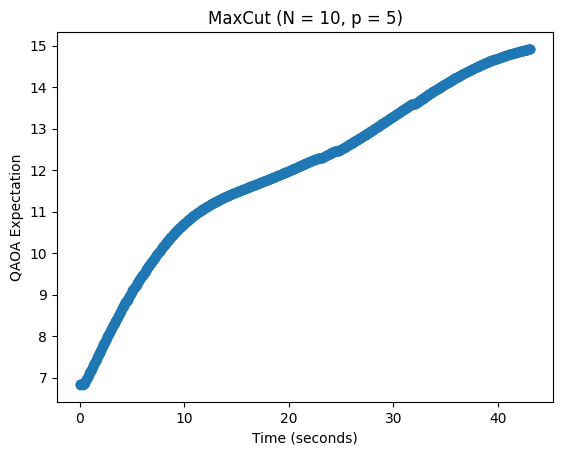

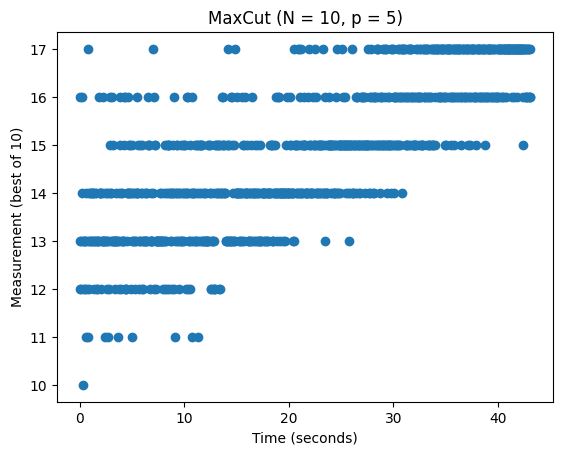

N = 1: Time to optimize = 0.004264354705810547 seconds
N = 2: Time to optimize = 0.27150845527648926 seconds
N = 3: Time to optimize = 0.17891740798950195 seconds
N = 4: Time to optimize = 0.32602763175964355 seconds
N = 5: Time to optimize = 0.20201349258422852 seconds
N = 6: Time to optimize = 0.4203798770904541 seconds
N = 7: Time to optimize = 0.8278160095214844 seconds
N = 8: Time to optimize = 1.4850027561187744 seconds
N = 9: Time to optimize = 2.824726104736328 seconds
N = 10: Time to optimize = 1.5661847591400146 seconds
N = 11: Time to optimize = 21.323566436767578 seconds


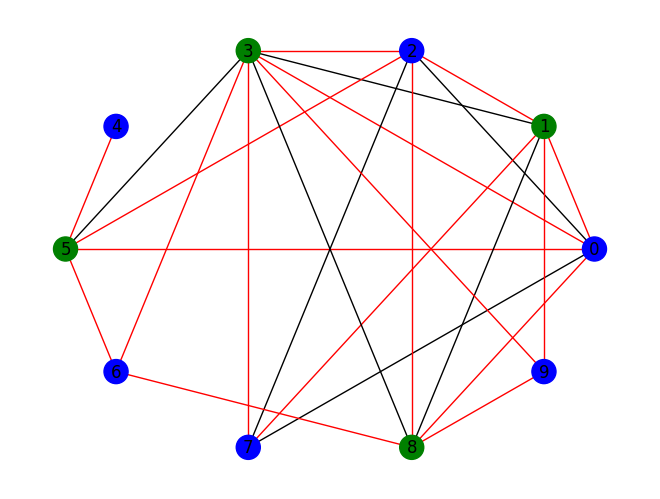

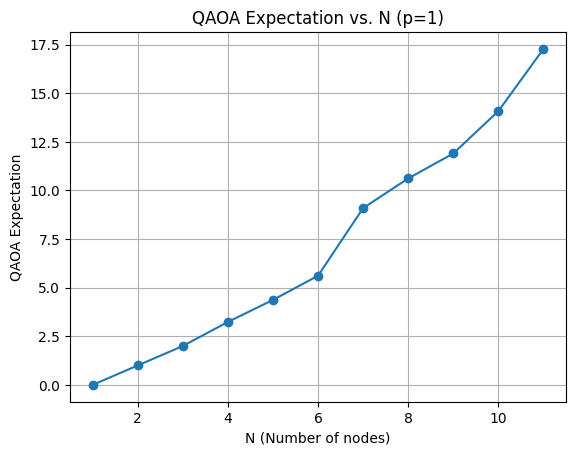

N = 1: Time to optimize = 0.005459785461425781 seconds
N = 2: Time to optimize = 0.2779970169067383 seconds
N = 3: Time to optimize = 0.16549253463745117 seconds
N = 4: Time to optimize = 0.6636722087860107 seconds
N = 5: Time to optimize = 0.880016565322876 seconds
N = 6: Time to optimize = 1.315450668334961 seconds
N = 7: Time to optimize = 2.3805298805236816 seconds
N = 8: Time to optimize = 4.401429176330566 seconds
N = 9: Time to optimize = 8.648292303085327 seconds
N = 10: Time to optimize = 17.809980869293213 seconds
N = 11: Time to optimize = 23.96026349067688 seconds


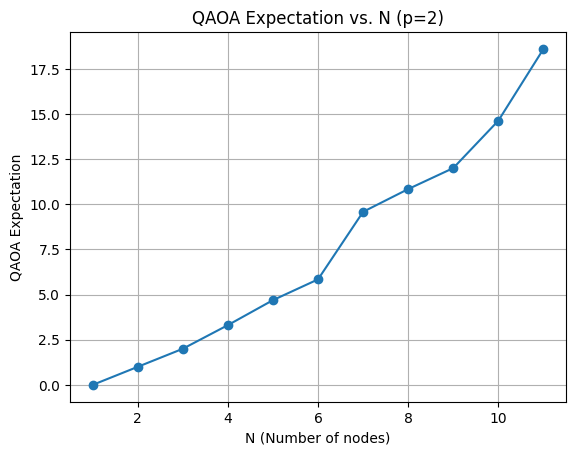

N = 1: Time to optimize = 0.008574247360229492 seconds
N = 2: Time to optimize = 0.2588498592376709 seconds
N = 3: Time to optimize = 0.13141703605651855 seconds
N = 4: Time to optimize = 0.6989140510559082 seconds
N = 5: Time to optimize = 0.9992783069610596 seconds
N = 6: Time to optimize = 1.6061906814575195 seconds
N = 7: Time to optimize = 3.025822401046753 seconds
N = 8: Time to optimize = 5.885817050933838 seconds
N = 9: Time to optimize = 12.31766963005066 seconds
N = 10: Time to optimize = 26.237929821014404 seconds
N = 11: Time to optimize = 56.22757267951965 seconds


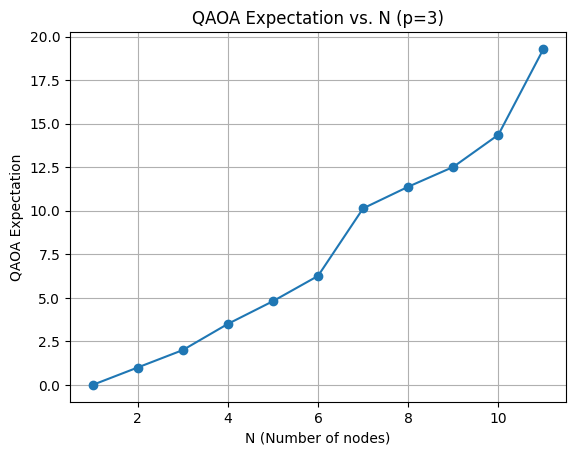

N = 1: Time to optimize = 0.011940956115722656 seconds
N = 2: Time to optimize = 0.175889253616333 seconds
N = 3: Time to optimize = 0.08171534538269043 seconds
N = 4: Time to optimize = 0.7724378108978271 seconds
N = 5: Time to optimize = 1.139702558517456 seconds
N = 6: Time to optimize = 1.9685883522033691 seconds
N = 7: Time to optimize = 3.8064582347869873 seconds
N = 8: Time to optimize = 7.558593273162842 seconds
N = 9: Time to optimize = 15.675312757492065 seconds
N = 10: Time to optimize = 34.341031551361084 seconds
N = 11: Time to optimize = 73.9934504032135 seconds


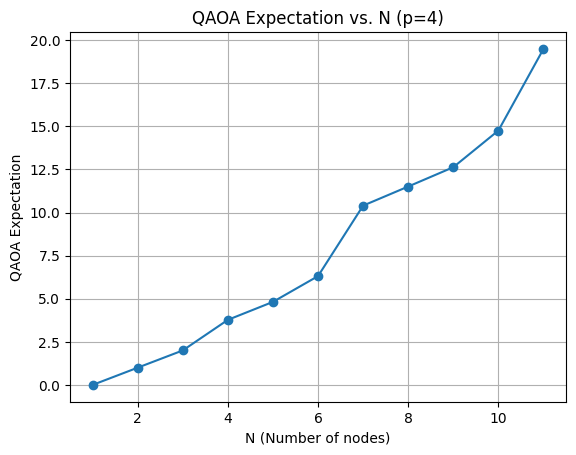

N = 1: Time to optimize = 0.01455831527709961 seconds
N = 2: Time to optimize = 0.19143390655517578 seconds
N = 3: Time to optimize = 0.09661173820495605 seconds
N = 4: Time to optimize = 0.8290934562683105 seconds
N = 5: Time to optimize = 1.3021109104156494 seconds
N = 6: Time to optimize = 2.2667524814605713 seconds
N = 7: Time to optimize = 4.6160383224487305 seconds
N = 8: Time to optimize = 9.443570137023926 seconds
N = 9: Time to optimize = 19.4338538646698 seconds
N = 10: Time to optimize = 42.42848992347717 seconds
N = 11: Time to optimize = 91.56976675987244 seconds


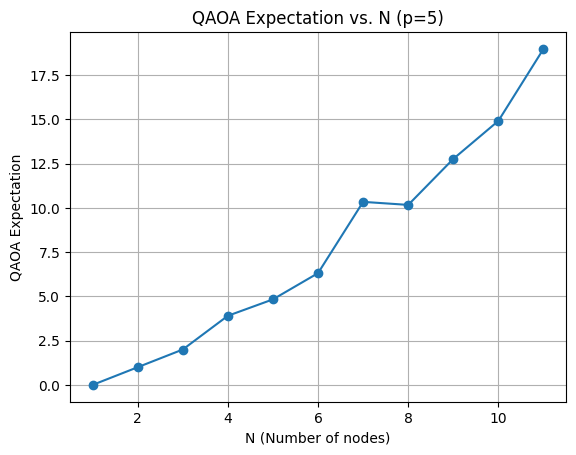

N = 1: Time to optimize = 0.014773368835449219 seconds
N = 2: Time to optimize = 0.18382740020751953 seconds
N = 3: Time to optimize = 0.13338828086853027 seconds
N = 4: Time to optimize = 0.8980941772460938 seconds
N = 5: Time to optimize = 1.4029381275177002 seconds
N = 6: Time to optimize = 2.537182331085205 seconds
N = 7: Time to optimize = 5.255160808563232 seconds
N = 8: Time to optimize = 11.130377054214478 seconds
N = 9: Time to optimize = 23.14299988746643 seconds
N = 10: Time to optimize = 50.00291609764099 seconds
N = 11: Time to optimize = 110.43279814720154 seconds


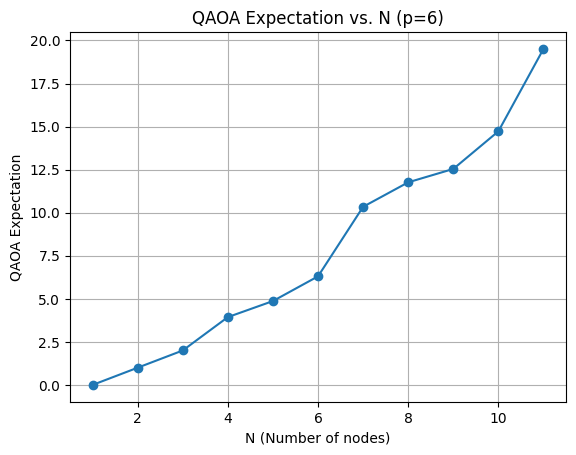

N = 1: Time to optimize = 0.018134593963623047 seconds
N = 2: Time to optimize = 0.22124743461608887 seconds
N = 3: Time to optimize = 0.08916258811950684 seconds
N = 4: Time to optimize = 0.9922003746032715 seconds
N = 5: Time to optimize = 1.6006462574005127 seconds
N = 6: Time to optimize = 3.993201494216919 seconds
N = 7: Time to optimize = 6.109725475311279 seconds
N = 8: Time to optimize = 13.925023555755615 seconds
N = 9: Time to optimize = 30.992854833602905 seconds
N = 10: Time to optimize = 62.75634407997131 seconds
N = 11: Time to optimize = 134.92783379554749 seconds


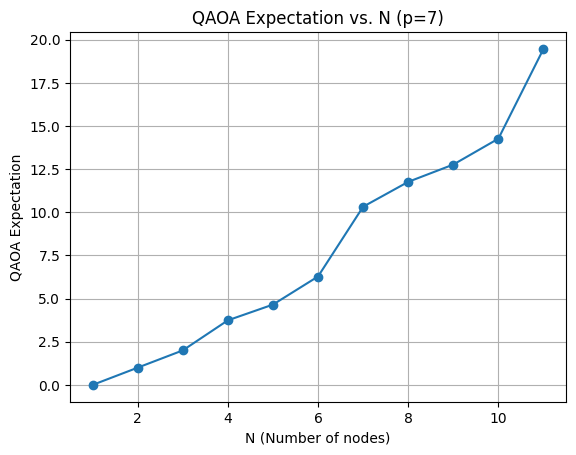

N = 1: Time to optimize = 0.027119874954223633 seconds
N = 2: Time to optimize = 0.2369518280029297 seconds
N = 3: Time to optimize = 0.16522502899169922 seconds
N = 4: Time to optimize = 1.0541679859161377 seconds
N = 5: Time to optimize = 1.740112543106079 seconds
N = 6: Time to optimize = 3.410945177078247 seconds
N = 7: Time to optimize = 8.58138108253479 seconds
N = 8: Time to optimize = 14.840589046478271 seconds
N = 9: Time to optimize = 33.44778513908386 seconds
N = 10: Time to optimize = 70.33590841293335 seconds
N = 11: Time to optimize = 140.4964988231659 seconds


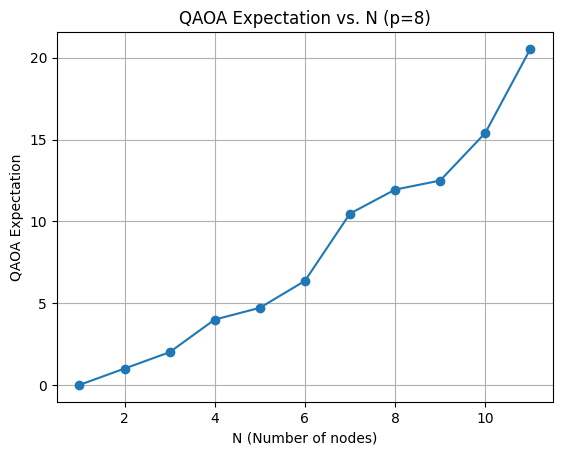

N = 1: Time to optimize = 0.026354312896728516 seconds
N = 2: Time to optimize = 0.24121975898742676 seconds
N = 3: Time to optimize = 0.1328871250152588 seconds
N = 4: Time to optimize = 1.0480928421020508 seconds
N = 5: Time to optimize = 1.7979722023010254 seconds
N = 6: Time to optimize = 3.418938398361206 seconds
N = 7: Time to optimize = 7.250838756561279 seconds
N = 8: Time to optimize = 15.362107515335083 seconds
N = 9: Time to optimize = 33.039915800094604 seconds
N = 10: Time to optimize = 72.13240694999695 seconds
N = 11: Time to optimize = 157.21025776863098 seconds


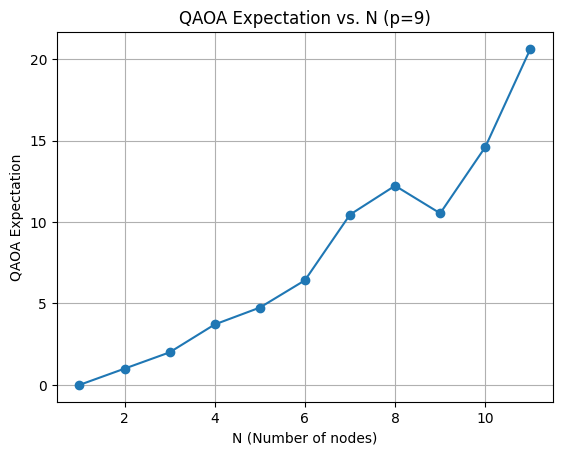

N = 1: Time to optimize = 0.028817415237426758 seconds
N = 2: Time to optimize = 0.45203590393066406 seconds
N = 3: Time to optimize = 0.13073515892028809 seconds
N = 4: Time to optimize = 1.1196861267089844 seconds
N = 5: Time to optimize = 1.9362971782684326 seconds
N = 6: Time to optimize = 3.7287120819091797 seconds
N = 7: Time to optimize = 7.895430088043213 seconds
N = 8: Time to optimize = 17.118794202804565 seconds
N = 9: Time to optimize = 38.19747352600098 seconds
N = 10: Time to optimize = 82.70310354232788 seconds
N = 11: Time to optimize = 181.4278359413147 seconds


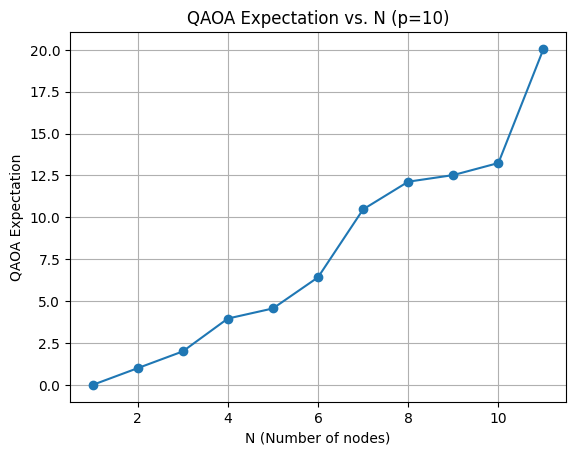

In [5]:
import qokit  # QAOAのシミュレーションに使用するqokitライブラリをインポート
import numpy as np  # 数値計算用のライブラリnumpyをインポート
from itertools import combinations  # 組み合わせを生成するitertoolsモジュールからcombinationsをインポート
import scipy  # 科学技術計算用ライブラリscipyをインポート
import networkx as nx  # グラフ理論を操作するnetworkxライブラリをインポート
import time  # 時間計測用のライブラリtimeをインポート
from matplotlib import pyplot as plt  # プロット用のmatplotlibのpyplotモジュールをインポート

expectations_along_the_way = []  # QAOA実行中の期待値の推移を記録するリスト
measurements_along_the_way = []  # QAOA実行中の測定結果の推移を記録するリスト
costs = []  # カットのコストを保持するリスト

def random_graph(N, prob_connect=0.7):
    """
    N個のノードを持つランダムなグラフを生成する関数。
    prob_connectの確率でノード間にエッジを生成する。

    Parameters:
    - N: グラフのノード数
    - prob_connect: ノード間にエッジを生成する確率

    Returns:
    - A: 隣接行列
    - G: networkxのグラフオブジェクト
    """
    A = np.random.choice([0, 1], (N, N), p=[1 - prob_connect, prob_connect])
    np.fill_diagonal(A, 0)  # 自己ループを禁止
    A = np.triu(A)  # 上三角部分のみ使用
    A += A.T  # 行列を対称にする
    return (A, nx.from_numpy_array(A))

def max_cut_terms_for_graph(G):
    """
    最大カット問題の項を生成する関数。
    グラフGのエッジごとに項を生成し、最後に全結合項を追加する。

    Parameters:
    - G: networkxのグラフオブジェクト

    Returns:
    - terms: 最大カット問題の項のリスト
    """
    return list(map((lambda edge: (-0.5, edge)), G.edges)) + [((G.number_of_edges() / 2.0), ())]

def print_result(N, terms, gamma, beta, adjective=""):
    """
    QAOAの実行結果を出力する関数。
    gamma, beta, 目的関数の値を表示する。

    Parameters:
    - N: グラフのノード数
    - terms: 最大カット問題の項のリスト
    - gamma: QAOAのγパラメータ
    - beta: QAOAのβパラメータ
    - adjective: 接頭辞として付ける形容詞（オプション）

    Returns:
    - None
    """
    p = len(gamma)
    print(f"{adjective}Gamma: {gamma}")
    print(f"{adjective}Beta: {beta}")
    print(f"{adjective}Objective: {-inv_max_cut_objective(N, p, terms)(np.hstack([gamma, beta]))}")
    print()

def evaluate_cut(G, bool_verts):
    """
    カットの数を評価する関数。
    bool_vertsで指定されたカットにおけるカットの数を数える。

    Parameters:
    - G: networkxのグラフオブジェクト
    - bool_verts: カットを表すブール値のリスト

    Returns:
    - cuts: カットの数
    """
    cuts = 0
    for (u, v) in G.edges():
        if (bool_verts[u] != bool_verts[v]):
            cuts += 1
    return cuts

def get_probabilities(N, terms, gamma, beta):
    """
    QAOAの確率分布を取得する関数。

    Parameters:
    - N: グラフのノード数
    - terms: 最大カット問題の項のリスト
    - gamma: QAOAのγパラメータ
    - beta: QAOAのβパラメータ

    Returns:
    - probs: 各状態の確率分布
    """
    simclass = qokit.fur.choose_simulator(name='auto')
    sim = simclass(N, terms=terms)
    _result = sim.simulate_qaoa(gamma, beta)
    return sim.get_probabilities(_result)

def get_expectation(N, terms, gamma, beta):
    """
    QAOAの期待値を取得する関数。

    Parameters:
    - N: グラフのノード数
    - terms: 最大カット問題の項のリスト
    - gamma: QAOAのγパラメータ
    - beta: QAOAのβパラメータ

    Returns:
    - expectation: QAOAの期待値
    """
    simclass = qokit.fur.choose_simulator(name='auto')
    sim = simclass(N, terms=terms)
    _result = sim.simulate_qaoa(gamma, beta)
    return sim.get_expectation(_result)

def print_probabilities(G, terms, gamma, beta, threshold=0, only_likely=False, include_cost=True):
    """
    QAOAの実行結果の確率分布を表示する関数。

    Parameters:
    - G: networkxのグラフオブジェクト
    - terms: 最大カット問題の項のリスト
    - gamma: QAOAのγパラメータ
    - beta: QAOAのβパラメータ
    - threshold: 表示する確率の閾値
    - only_likely: 閾値を超える確率のみ表示するかどうか
    - include_cost: カットのコストを表示するかどうか

    Returns:
    - None
    """
    N = G.number_of_nodes()
    probs = get_probabilities(N, terms, gamma, beta)
    for element in np.column_stack((np.array(range(2**N)), probs)):
        [index, prob] = element
        likely_str = ""
        if (prob > threshold):
            likely_str = " <- Likely outcome"

        cost_str = ""
        if (include_cost):
            contained_verts = list(map(lambda c: c == '1', f"{int(index):0{N}b}"))
            contained_verts.reverse()
            cut_count = evaluate_cut(G, contained_verts)
            cost_str = f" ({cut_count})"

        if (not only_likely):
            print(f"{int(index):0{N}b}{cost_str} - {prob}{likely_str}")
        else:
            if (prob > threshold):
                print(f"{int(index):0{N}b}{cost_str} - {prob}")

def get_state_vector(N, terms, gamma, beta):
    """
    QAOAの状態ベクトルを取得する関数。

    Parameters:
    - N: グラフのノード数
    - terms: 最大カット問題の項のリスト
    - gamma: QAOAのγパラメータ
    - beta: QAOAのβパラメータ

    Returns:
    - sv: QAOAの状態ベクトル
    """
    simclass = qokit.fur.choose_simulator(name='auto')
    sim = simclass(N, terms=terms)
    _result = sim.simulate_qaoa(gamma, beta)
    return sim.get_statevector(_result)

def print_state_vector(G, terms, gamma, beta, include_cost=True):
    """
    QAOAの状態ベクトルを表示する関数。

    Parameters:
    - G: networkxのグラフオブジェクト
    - terms: 最大カット問題の項のリスト
    - gamma: QAOAのγパラメータ
    - beta: QAOAのβパラメータ
    - include_cost: カットのコストを表示するかどうか

    Returns:
    - None
    """
    N = G.number_of_nodes()
    sv = get_state_vector(N, terms, gamma, beta)
    for element in np.column_stack((np.array(range(2**N)), sv)):
        [index, amplitude] = element
        cost_str = ""
        if (include_cost):
            contained_verts = list(map(lambda c: c == '1', f"{int(index):0{N}b}"))
            contained_verts.reverse()
            cut_count = evaluate_cut(G, contained_verts)
            cost_str = f" ({cut_count})"

        print(f"{int(index):0{N}b}{cost_str} - {amplitude}")

def set_costs(G):
    """
    グラフGのカットのコストを設定する関数。

    Parameters:
    - G: networkxのグラフオブジェクト

    Returns:
    - None
    """
    costs.clear()
    N = G.number_of_nodes()
    for index in range(2**N):
        contained_verts = list(map(lambda c: c == '1', f"{int(index):0{N}b}"))
        contained_verts.reverse()
        costs.append(evaluate_cut(G, contained_verts))

def inv_max_cut_objective(N, p, terms):
    """
    最大カット問題の目的関数の逆を定義する関数。

    Parameters:
    - N: グラフのノード数
    - p: QAOAのステップ数
    - terms: 最大カット問題の項のリスト

    Returns:
    - f: 目的関数の逆の関数
    """
    def f(*args):
        gamma, beta = args[0][:p], args[0][p:]
        current_time = time.time()

        expectation = get_expectation(N, terms, gamma, beta)
        expectations_along_the_way.append((current_time, expectation))

        if (len(costs) > 0):
            probs = get_probabilities(N, terms, gamma, beta)
            measurement = max(np.random.choice(costs, 10, p=probs))
            measurements_along_the_way.append((current_time, measurement))

        return -expectation
    return f

def optimize(N, terms, init_gamma, init_beta):
    """
    QAOAのパラメータを最適化する関数。

    Parameters:
    - N: グラフのノード数
    - terms: 最大カット問題の項のリスト
    - init_gamma: 初期のγパラメータ
    - init_beta: 初期のβパラメータ

    Returns:
    - gamma: 最適化されたγパラメータ
    - beta: 最適化されたβパラメータ
    """
    expectations_along_the_way.clear()
    measurements_along_the_way.clear()
    p = len(init_gamma)
    init_freq = np.hstack([init_gamma, init_beta])
    res = scipy.optimize.minimize(inv_max_cut_objective(N, p, terms), init_freq, method='COBYLA', options={'rhobeg': 0.01/N})
    gamma, beta = res.x[:p], res.x[p:]
    return (gamma, beta)

def plot_expectation(N, p, start_time):
    """
    QAOAの期待値の推移をプロットする関数。

    Parameters:
    - N: グラフのノード数
    - p: QAOAのステップ数
    - start_time: 実験開始時刻

    Returns:
    - None
    """
    def make_time_relative(input):
        time, expectation = input
        return (time - start_time, expectation)

    time_relative_expectations = list(map(make_time_relative, expectations_along_the_way))
    plt.scatter(*zip(*time_relative_expectations))
    plt.title(f"MaxCut (N = {N}, p = {p})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("QAOA Expectation")
    plt.show()

def plot_measurements(N, p, start_time):
    """
    QAOAの測定結果の推移をプロットする関数。

    Parameters:
    - N: グラフのノード数
    - p: QAOAのステップ数
    - start_time: 実験開始時刻

    Returns:
    - None
    """
    def make_time_relative(input):
        time, measurement = input
        return (time - start_time, measurement)

    time_relative_measurements = list(map(make_time_relative, measurements_along_the_way))
    plt.scatter(*zip(*time_relative_measurements))
    plt.title(f"MaxCut (N = {N}, p = {p})")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Measurement (best of 10)")
    plt.show()

def run_experiment(seed, N, p):
    """
    QAOAの実験を実行する関数。

    Parameters:
    - seed: 乱数シード
    - N: グラフのノード数
    - p: QAOAのステップ数

    Returns:
    - None
    """
    np.random.seed(seed)
    (A, G) = random_graph(N, 0.5)
    set_costs(G)
    solution = max(costs)
    solution_index = costs.index(solution)
    print(f"Optimal Solution: {solution_index:0{N}b} - {max(costs)}")
    vert_colors = list(map(lambda c: "green" if c == '1' else "blue", f"{int(solution_index):0{N}b}"))
    vert_colors.reverse()
    edge_colors = [("red" if vert_colors[u] != vert_colors[v] else "black") for u, v in G.edges()]

    terms = max_cut_terms_for_graph(G)
    init_gamma, init_beta = np.random.rand(2, p)

    print_result(N, terms, init_gamma, init_beta, "Initial ")

    start_time = time.time()
    gamma, beta = optimize(N, terms, init_gamma, init_beta)
    end_time = time.time()
    print(f"Time to optimize: {end_time - start_time} seconds\n")

    print_result(N, terms, gamma, beta, "Final ")
    print_probabilities(G, terms, gamma, beta, threshold=0.5/N, only_likely=True)
    print()
    plot_expectation(N, p, start_time)
    plot_measurements(N, p, start_time)

    nx.draw(G, nx.circular_layout(G), node_color=vert_colors, edge_color=edge_colors, with_labels=True)
    return  # ここで return 文を追加する

# 実験の実行（N=10, p=5）
run_experiment(seed=0, N=10, p=5)

def set_costs(G):
    """
    グラフGのカットのコストを設定する関数。

    Parameters:
    - G: networkxのグラフオブジェクト

    Returns:
    - None
    """
    global costs  # global宣言でcostsを関数外の変数として扱う
    costs = []
    N = G.number_of_nodes()
    for index in range(2**N):
        contained_verts = list(map(lambda c: c == '1', f"{int(index):0{N}b}"))
        contained_verts.reverse()
        costs.append(evaluate_cut(G, contained_verts))

def run_experiments_for_different_Ns(seed, N_values, p):
    expectations = []

    for N in N_values:
        np.random.seed(seed)
        (A, G) = random_graph(N, 0.5)
        set_costs(G)
        terms = max_cut_terms_for_graph(G)
        init_gamma, init_beta = np.random.rand(2, p)

        start_time = time.time()
        gamma, beta = optimize(N, terms, init_gamma, init_beta)
        end_time = time.time()
        print(f"N = {N}: Time to optimize = {end_time - start_time} seconds")

        expectation = get_expectation(N, terms, gamma, beta)
        expectations.append(expectation)

    return N_values, expectations

# Nの値を設定
N_values = [1,2,3,4,5,6,7,8,9,10,11]

# 実験を実行して期待値を取得
seed = 0  # 乱数シード
p = 1  # QAOAのステップ数
N_values, expectations = run_experiments_for_different_Ns(seed, N_values, p)

# 結果をプロット
plt.figure()
plt.plot(N_values, expectations, marker='o')
plt.title(f'QAOA Expectation vs. N (p={p})')
plt.xlabel('N (Number of nodes)')
plt.ylabel('QAOA Expectation')
plt.grid(True)
plt.show()


# 実験を実行して期待値を取得
seed = 0  # 乱数シード
p = 2  # QAOAのステップ数
N_values, expectations = run_experiments_for_different_Ns(seed, N_values, p)

# 結果をプロット
plt.figure()
plt.plot(N_values, expectations, marker='o')
plt.title(f'QAOA Expectation vs. N (p={p})')
plt.xlabel('N (Number of nodes)')
plt.ylabel('QAOA Expectation')
plt.grid(True)
plt.show()

# 実験を実行して期待値を取得
seed = 0  # 乱数シード
p = 3  # QAOAのステップ数
N_values, expectations = run_experiments_for_different_Ns(seed, N_values, p)

# 結果をプロット
plt.figure()
plt.plot(N_values, expectations, marker='o')
plt.title(f'QAOA Expectation vs. N (p={p})')
plt.xlabel('N (Number of nodes)')
plt.ylabel('QAOA Expectation')
plt.grid(True)
plt.show()

# 実験を実行して期待値を取得
seed = 0  # 乱数シード
p = 4  # QAOAのステップ数
N_values, expectations = run_experiments_for_different_Ns(seed, N_values, p)

# 結果をプロット
plt.figure()
plt.plot(N_values, expectations, marker='o')
plt.title(f'QAOA Expectation vs. N (p={p})')
plt.xlabel('N (Number of nodes)')
plt.ylabel('QAOA Expectation')
plt.grid(True)
plt.show()

# 実験を実行して期待値を取得
seed = 0  # 乱数シード
p = 5  # QAOAのステップ数
N_values, expectations = run_experiments_for_different_Ns(seed, N_values, p)

# 結果をプロット
plt.figure()
plt.plot(N_values, expectations, marker='o')
plt.title(f'QAOA Expectation vs. N (p={p})')
plt.xlabel('N (Number of nodes)')
plt.ylabel('QAOA Expectation')
plt.grid(True)
plt.show()

# 実験を実行して期待値を取得
seed = 0  # 乱数シード
p = 6  # QAOAのステップ数
N_values, expectations = run_experiments_for_different_Ns(seed, N_values, p)

# 結果をプロット
plt.figure()
plt.plot(N_values, expectations, marker='o')
plt.title(f'QAOA Expectation vs. N (p={p})')
plt.xlabel('N (Number of nodes)')
plt.ylabel('QAOA Expectation')
plt.grid(True)
plt.show()

# 実験を実行して期待値を取得
seed = 0  # 乱数シード
p = 7  # QAOAのステップ数
N_values, expectations = run_experiments_for_different_Ns(seed, N_values, p)

# 結果をプロット
plt.figure()
plt.plot(N_values, expectations, marker='o')
plt.title(f'QAOA Expectation vs. N (p={p})')
plt.xlabel('N (Number of nodes)')
plt.ylabel('QAOA Expectation')
plt.grid(True)
plt.show()

# 実験を実行して期待値を取得
seed = 0  # 乱数シード
p = 8  # QAOAのステップ数
N_values, expectations = run_experiments_for_different_Ns(seed, N_values, p)

# 結果をプロット
plt.figure()
plt.plot(N_values, expectations, marker='o')
plt.title(f'QAOA Expectation vs. N (p={p})')
plt.xlabel('N (Number of nodes)')
plt.ylabel('QAOA Expectation')
plt.grid(True)
plt.show()

# 実験を実行して期待値を取得
seed = 0  # 乱数シード
p = 9  # QAOAのステップ数
N_values, expectations = run_experiments_for_different_Ns(seed, N_values, p)

# 結果をプロット
plt.figure()
plt.plot(N_values, expectations, marker='o')
plt.title(f'QAOA Expectation vs. N (p={p})')
plt.xlabel('N (Number of nodes)')
plt.ylabel('QAOA Expectation')
plt.grid(True)
plt.show()

# 実験を実行して期待値を取得
seed = 0  # 乱数シード
p = 10  # QAOAのステップ数
N_values, expectations = run_experiments_for_different_Ns(seed, N_values, p)

# 結果をプロット
plt.figure()
plt.plot(N_values, expectations, marker='o')
plt.title(f'QAOA Expectation vs. N (p={p})')
plt.xlabel('N (Number of nodes)')
plt.ylabel('QAOA Expectation')
plt.grid(True)
plt.show()